In [1]:
import wandb
from tsai.all import *
from pathlib import Path

In [2]:
dataset_path = Path("./")
data = np.load(dataset_path/"downsampled_signals.npy")
data.shape

(6877, 12, 5000)

In [3]:
with open("./mlb.pickle", "rb") as f:
    import pickle
    mlb = pickle.load(f)

In [4]:
df = pd.read_csv(dataset_path/"labels.csv", index_col=0)
X, y = data.transpose((0,1,2)), df.values

In [5]:
classes = list(set(mlb.inverse_transform(y)))
l = mlb.inverse_transform(y)

In [6]:
class_map = {
    str(i): val for i, val in enumerate(classes)
}
inverse_class_map = {
    val: str(i) for i, val in enumerate(classes)
}

In [7]:
labels = [
    inverse_class_map[i] for i in l
]

In [8]:
labeler = ReLabeler(class_map)
l = np.array(l)
y_multi = labeler(l)
y_multi

array([list(['164889003']), list(['164889003', '59118001']),
       list(['429622005']), ..., list(['270492004']),
       list(['164889003', '59118001']), list(['284470004'])], dtype=object)

In [9]:
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'164889003': 1221, '59118001': 1857, '429622005': 869, '284470004': 616, '426783006': 918, '164884008': 700, '270492004': 722, '164931005': 220, '164909002': 236}


In [10]:
idx = range_of(len(X))
from sklearn.model_selection import train_test_split

splits = train_test_split(idx, test_size=0.1, shuffle=True)

In [11]:
tfms  = [None, TSMultiLabelClassification()] # TSMultiLabelClassification() == [MultiCategorize(), OneHotEncode()]
batch_tfms = TSStandardize()
dls = get_ts_dls(X, y_multi, tfms=tfms, batch_tfms=batch_tfms, bs=[128], splits=splits)
dls.dataset

(#6189) [(TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0.])), (TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0.])), (TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 0.])), (TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0.])), (TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0.])), (TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1.])), (TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1.])), (TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 1.])), (TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0.])), (TSTensor(vars:12, len:5000, device=cpu), TensorMultiCategory([0., 1., 0.

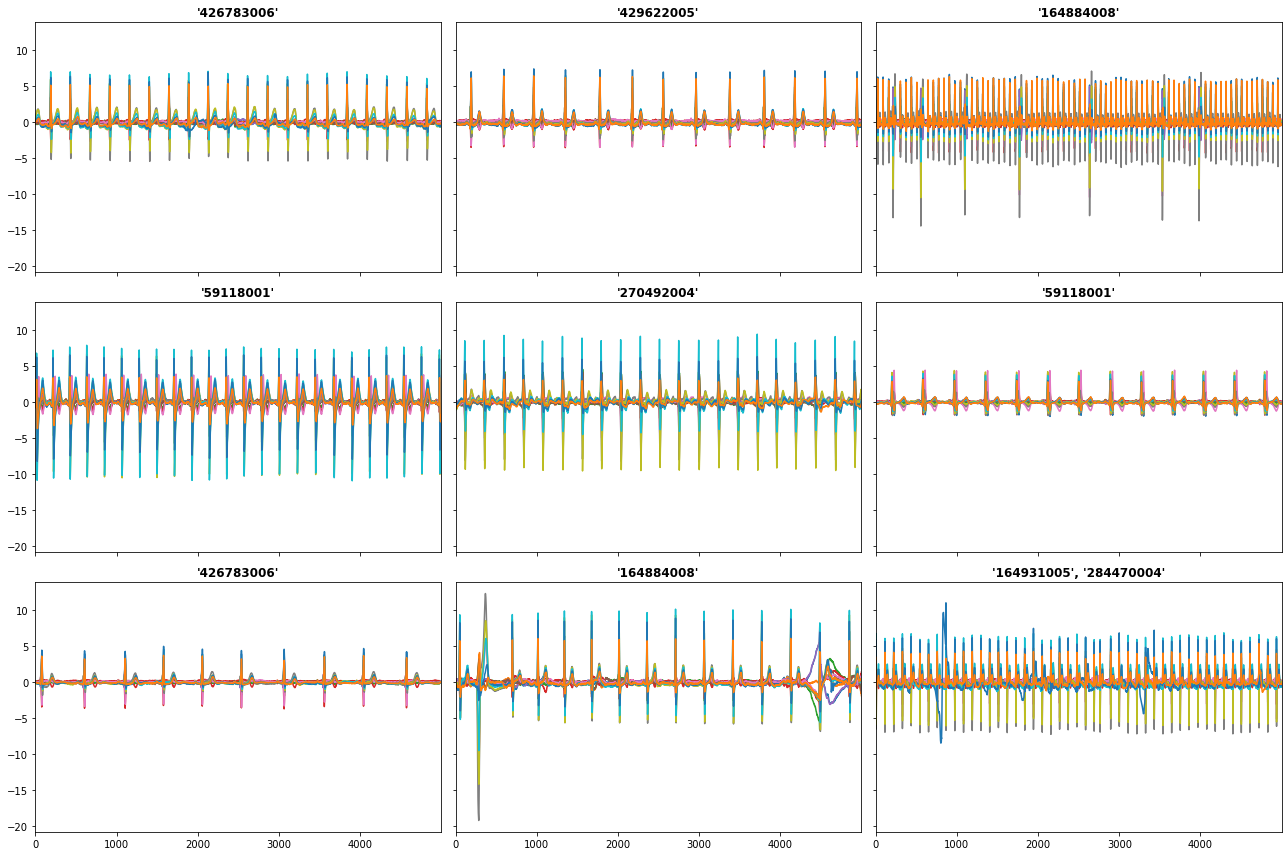

In [12]:
dls.show_batch(sharey=True)

In [13]:
def accuracy_multi_complete(inp, targ, thresh=0.5, sigmoid=True, by_sample=True):
    "Computes accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    correct = (inp>thresh)==targ.bool()
    if by_sample:
        return (correct.float().mean(-1) == 1).float().mean()
    else:
        inp,targ = flatten_check(inp,targ)
        return correct.float().mean()

def accuracy_multi_partial(inp, targ, thresh=0.5, sigmoid=True, by_sample=False):
    "Computes accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    correct = (inp>thresh)==targ.bool()
    if by_sample:
        return (correct.float().mean(-1) == 1).float().mean()
    else:
        inp,targ = flatten_check(inp,targ)
        return correct.float().mean()

In [14]:
# run = wandb.init(project="PhysioNet_Challenge", name="InceptionTime")
# run.use_artifact("manan-goel/PhysioNet_Challenge/preprocessed_dataset:v0")

In [23]:
from fastai.callback.wandb import WandbCallback

In [24]:
wandb_callback = WandbCallback(log_model=False, log_preds=False)

In [25]:
# wandb.finish()

In [15]:
def precision_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes precision when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    precision = TP/(TP+FP)
    return precision

def recall_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes recall when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    FN = torch.logical_and(~correct, (targ==1).bool()).sum()

    recall = TP/(TP+FN)
    return recall

def specificity_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes specificity (true negative rate) when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TN = torch.logical_and(correct,  (targ==0).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    specificity = TN/(TN+FP)
    return specificity

def balanced_accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes balanced accuracy when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    TN = torch.logical_and(correct,  (targ==0).bool()).sum()
    FN = torch.logical_and(~correct, (targ==1).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    balanced_accuracy = (TPR+TNR)/2
    return balanced_accuracy

def Fbeta_multi(inp, targ, beta=1.0, thresh=0.5, sigmoid=True):
    "Computes Fbeta when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    TN = torch.logical_and(correct,  (targ==0).bool()).sum()
    FN = torch.logical_and(~correct, (targ==1).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    beta2 = beta*beta
    
    if precision+recall > 0:
        Fbeta = (1+beta2)*precision*recall/(beta2*precision+recall)
    else:
        Fbeta = 0
    return Fbeta

def F1_multi(*args, **kwargs):
    return Fbeta_multi(*args, **kwargs)  # beta defaults to 1.0

In [16]:
from fastai.callback.fp16 import MixedPrecision

In [19]:
from tsai.models.ROCKET_Pytorch import ROCKET

In [17]:
metrics =[balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
learn = ts_learner(dls, Rocket(12, 5000), metrics=metrics, cbs=[ShowGraph(), MixedPrecision()])
learn.fit_one_cycle(20, lr_max=1e-3)

NameError: name 'Rocket' is not defined

In [29]:
wandb.finish()

F1_multi,▁▂▃▄▅▅▆▆▆▇▇▇▇▇██████
balanced_accuracy_multi,▁▁▂▄▄▅▆▅▆▇▇▇▇▇██████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
precision_multi,▁██▇█▇█▇█▇▇██▇██████
raw_loss,█▇▆▅▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
recall_multi,▂▁▂▄▄▅▆▆▆▇▇▇▇▇██████
specificity_multi,▁████▇▇▇█▇▇▇▇▇▇▇▇▇▇▇
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
